In [29]:
#change directory
import os
os.chdir('/Users/kaixianglim/Documents/DSS5104/Group_Project/5-min frequency data')

import numpy as np 
import pylab as plt
import pandas as pd
import sklearn
from scipy.stats import zscore
import xgboost as xgb

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV


In [30]:
# load file 'combined_df.csv'
df = pd.read_csv('combined_df.csv')


In [31]:
#df header
df.head()

,timestamp,Energy_Demand,Energy_Price,Crude_Oil_Price,Natural_Gas_Price,Rainfall,Carbon_Intensity,Renewable_Energy_Percentage,Temperature,Solar_Exposure
0,1/1/22 0:05,7206.03,124.86,NaN,NaN,0.0,324.42,56.31,22,0
1,1/1/22 0:10,7174.26,126.02,NaN,NaN,0.0,324.42,56.31,22,0
2,1/1/22 0:15,7135.00,124.93,NaN,NaN,0.0,324.42,56.31,22,0
3,1/1/22 0:20,7065.84,113.54,NaN,NaN,0.0,324.42,56.31,22,0
4,1/1/22 0:25,6995.08,123.12,NaN,NaN,0.0,324.42,56.31,22,0


In [ ]:
df_target = 'Energy_Price'
df_predictors = [col for col in df.columns if col != df_target]

In [33]:
#drop all rows with NaN values
df = df.dropna()

In [34]:
#drop all rows with negative value for target variable
df = df[df[df_target] >= 0]

In [35]:
#remove outliers using z-score
z_scores = zscore(df[df_target])
df = df[(abs(z_scores) < 3)]

In [38]:
#set timestamp as index
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df.set_index('timestamp', inplace=True)

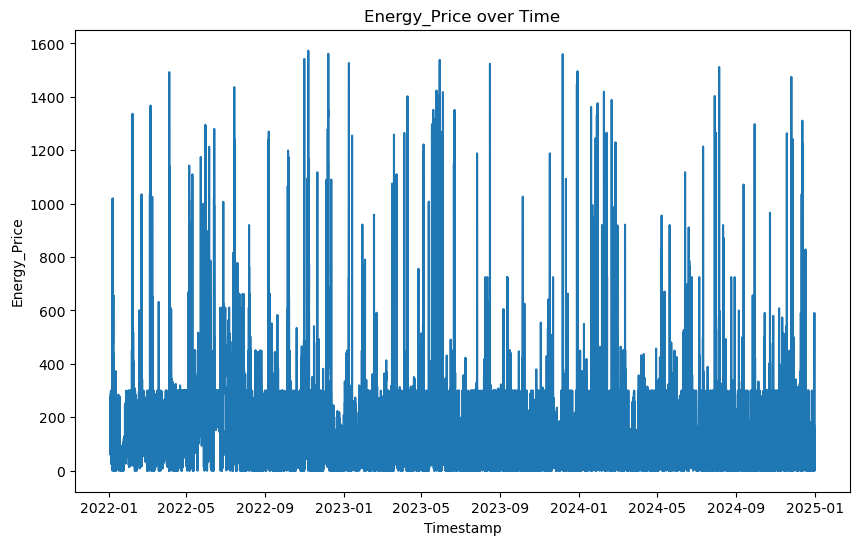

In [39]:
#plot target variable against index
plt.figure(figsize=(10, 6))
plt.plot(df[df_target])
plt.title(f"{df_target} over Time")
plt.xlabel('Timestamp')
plt.ylabel(f"{df_target}")
plt.show()

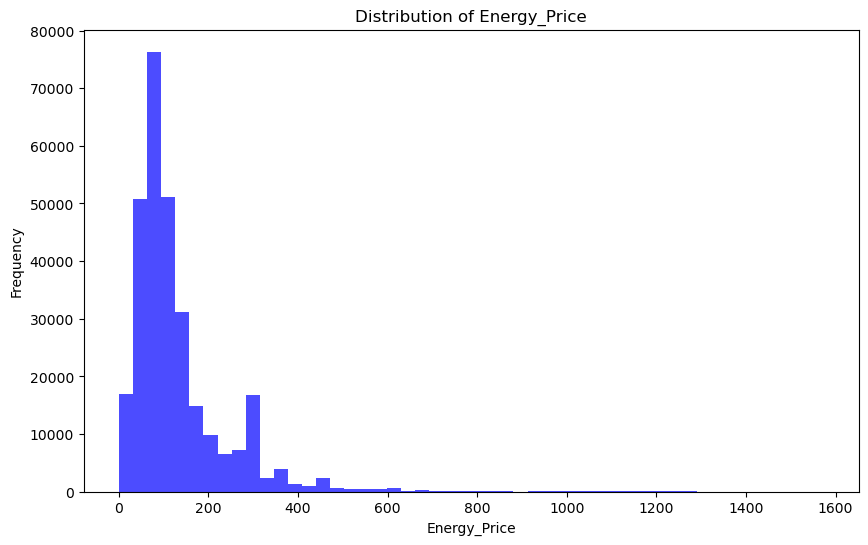

In [40]:
#plot distribution of target variable
plt.figure(figsize=(10, 6))
plt.hist(df[df_target], bins=50, color='blue', alpha=0.7)
plt.title(f"Distribution of {df_target}")
plt.xlabel(f"{df_target}")
plt.ylabel('Frequency')
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x16dce6a80>,
 'caps': [<matplotlib.lines.Line2D at 0x17d852660>,
 'boxes': [<matplotlib.lines.Line2D at 0x17d836300>],
 'medians': [<matplotlib.lines.Line2D at 0x17d852c00>],
 'fliers': [<matplotlib.lines.Line2D at 0x17d852ed0>],
 'means': []}

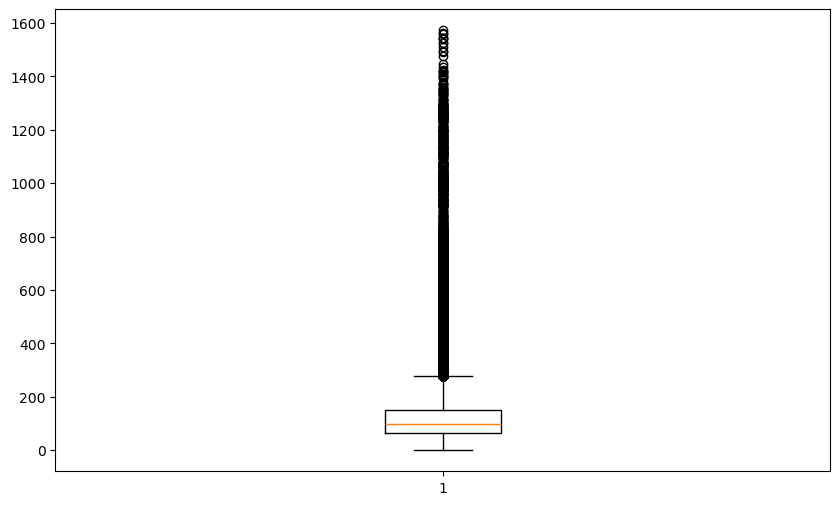

In [41]:
# show boxplot of target variable
plt.figure(figsize=(10, 6))
plt.boxplot(df[df_target])

In [42]:
#how many row are above 3rd quartile
q3 = df[df_target].quantile(0.75)
q1 = df[df_target].quantile(0.25)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
upper_bound
#number of rows above upper bound
len(df[df[df_target] > upper_bound])

#number of rows in total
len(df)

#percentage of rows above upper bound
len(df[df[df_target] > upper_bound]) / len(df) * 100


11.079802078979654

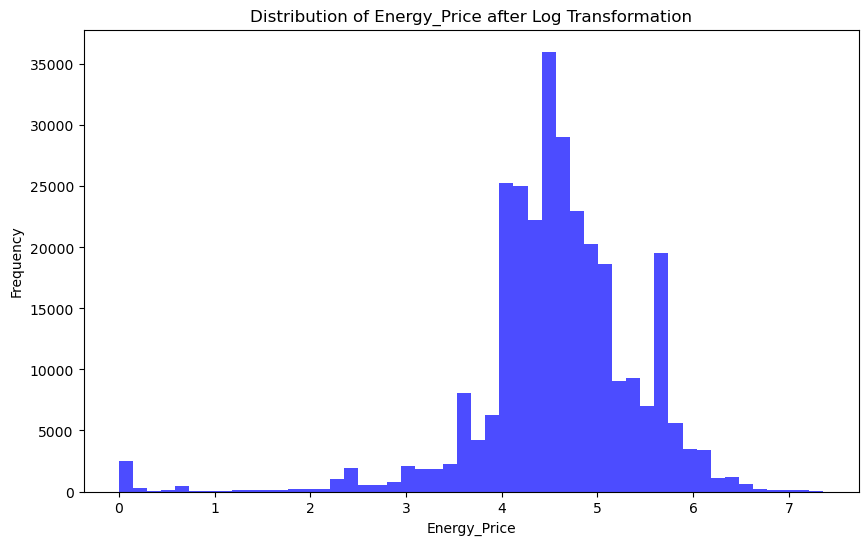

In [43]:
#log transform "df_target"
df[df_target] = np.log1p(df[df_target])

#plot distribution of target variable
plt.figure(figsize=(10, 6))
plt.hist(df[df_target], bins=50, color='blue', alpha=0.7)
plt.title(f"Distribution of {df_target} after Log Transformation")
plt.xlabel(f"{df_target}")
plt.ylabel('Frequency')
plt.show()

<Figure size 1000x600 with 0 Axes>

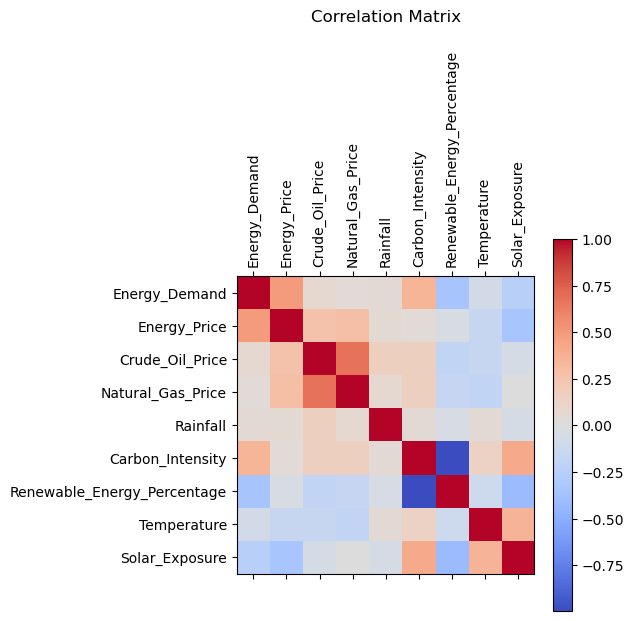

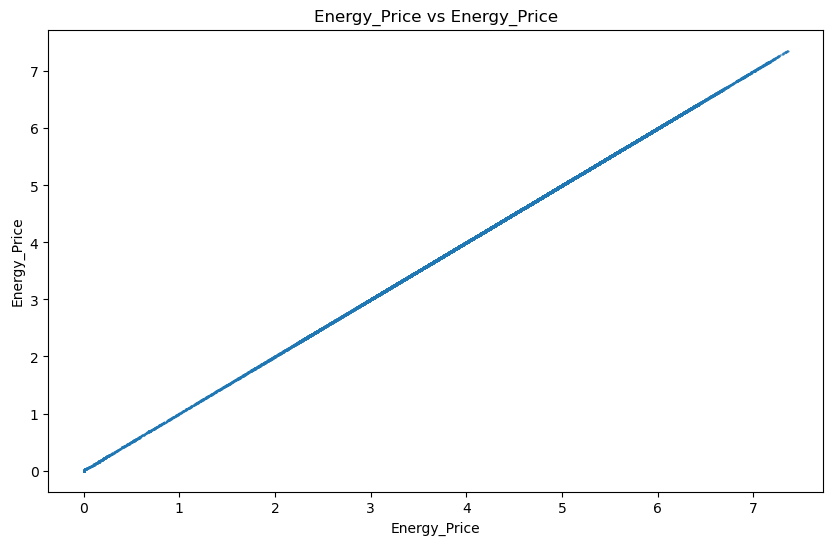

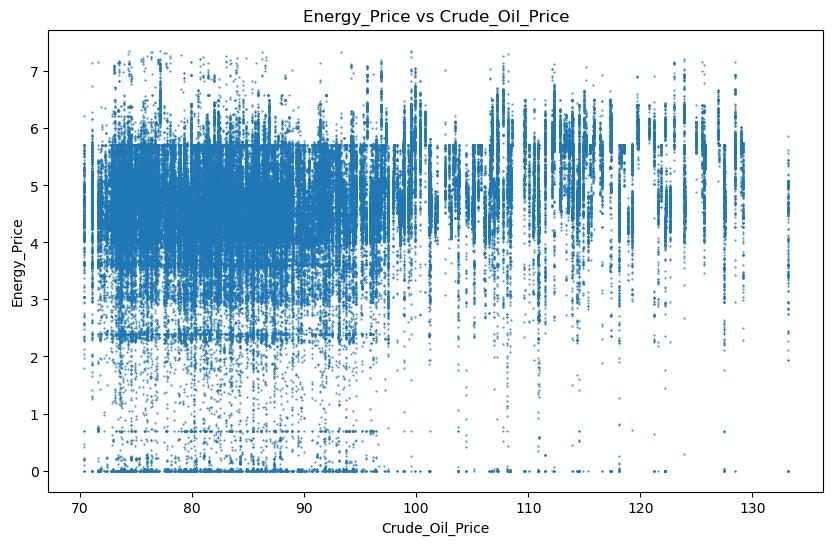

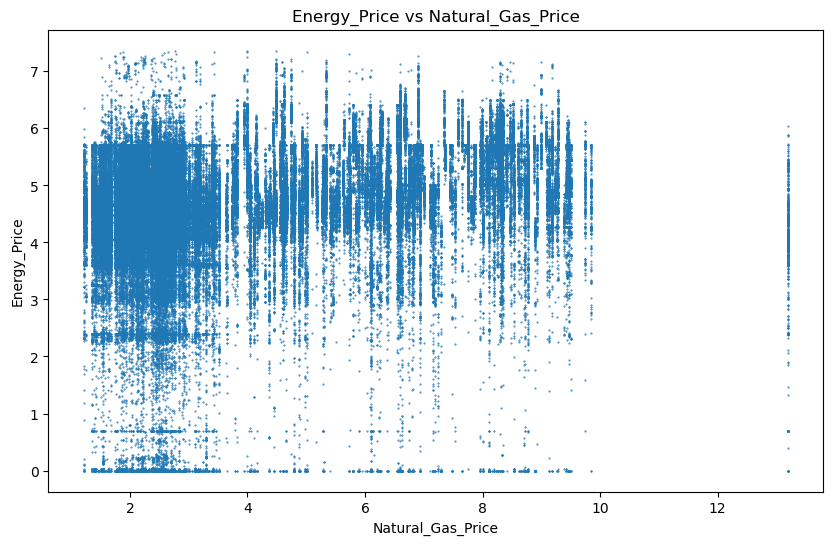

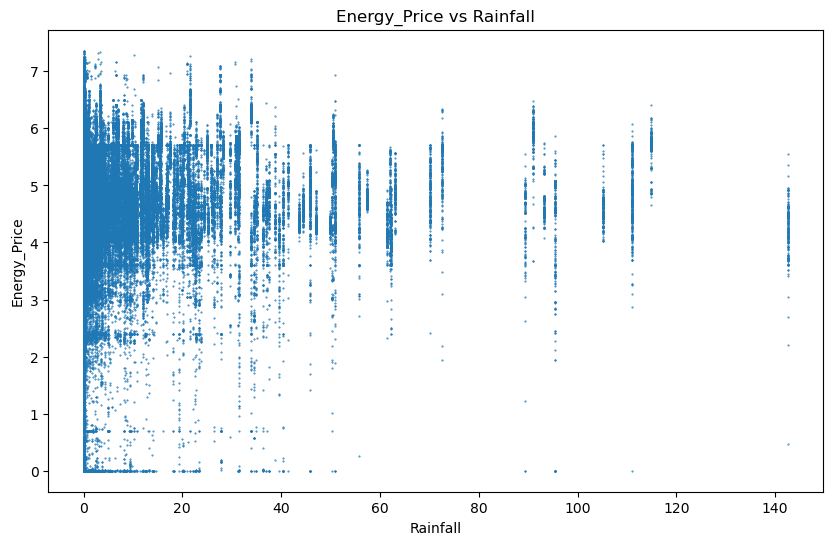

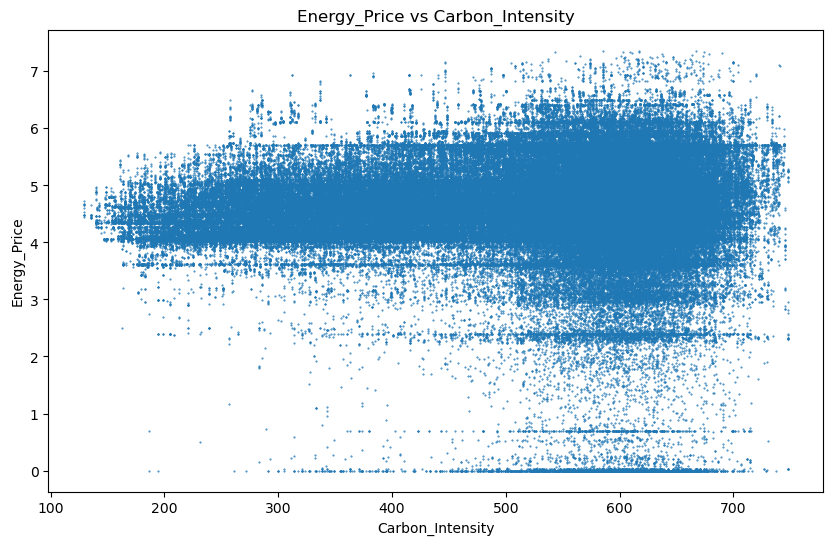

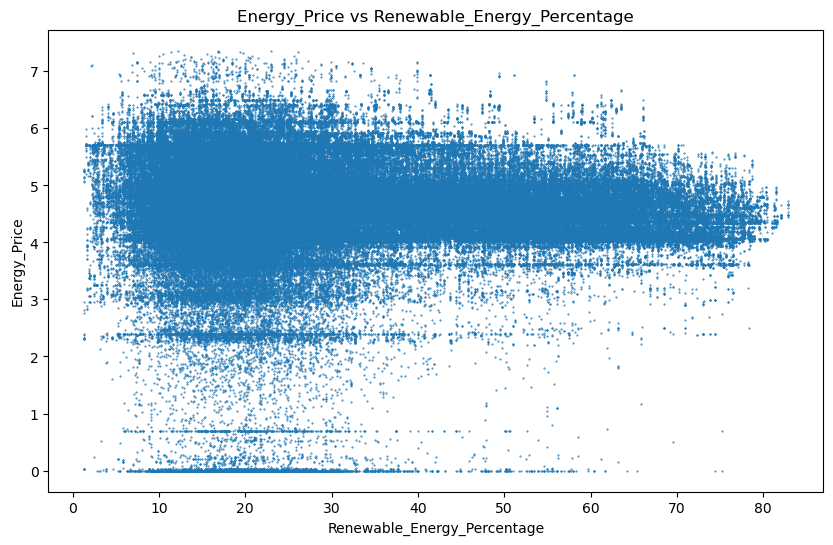

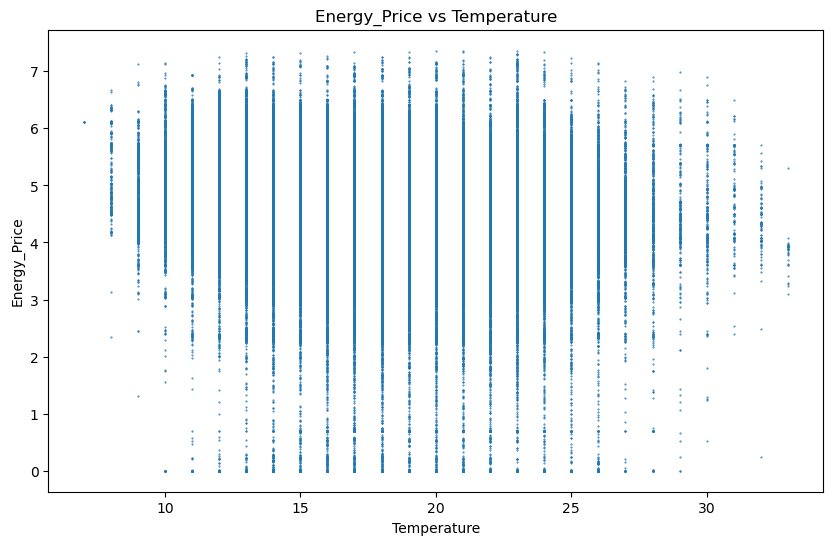

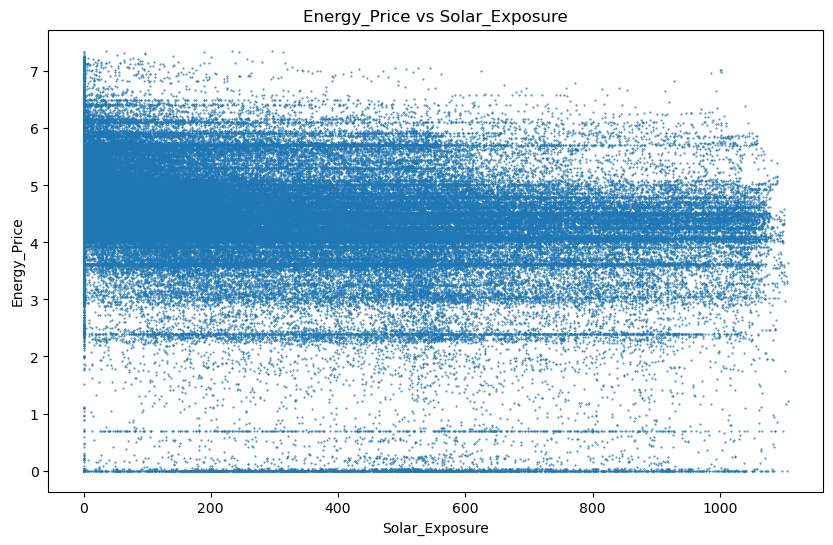

In [44]:
#correlation matrix, all columns except "timestamp"
correlations = df.corr()

#show correlation matrix
plt.figure(figsize=(10, 6))
plt.matshow(correlations, cmap='coolwarm')
plt.title('Correlation Matrix', pad=20)
plt.colorbar()
plt.xticks(range(len(correlations.columns)), correlations.columns, rotation=90)
plt.yticks(range(len(correlations.columns)), correlations.columns)
plt.show()

#plot target variable against all other columns in separate plots
columns = df.columns[1:]
for column in columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(df[column], df[df_target],s=0.2)
    plt.title(f"{df_target} vs {column}")
    plt.xlabel(column)
    plt.ylabel(f"{df_target}")
    plt.show()

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=0.8; total time=   2.3s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   3.0s
[CV] END cols

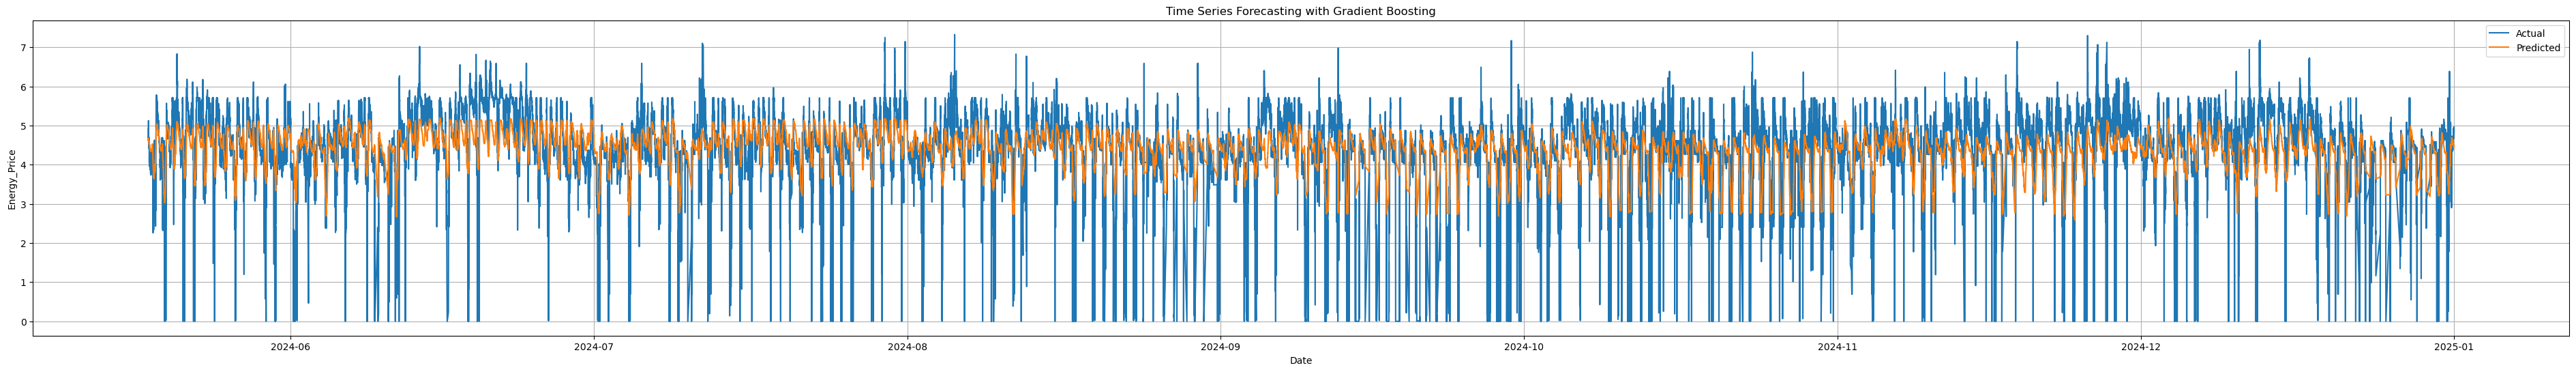

In [47]:
# 1. Prepare the Data

#all other columns are predictors
y = df[df_target]
X = df.drop(columns=[df_target])

# 2. Split the Data into Training and Testing Sets
# It's crucial to split time series data chronologically to avoid data leakage
train_size = int(len(df) * 0.8)  # Use 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 3. Initialize and Train the Gradient Boosting Regressor
# You can tune the hyperparameters for better performance
#xgbm = xgb.XGBRegressor(n_estimators=100,  # Number of boosting stages
                                #learning_rate=0.1, # Step size shrinkage to prevent overfitting
                                #max_depth=5,       # Maximum depth of the individual regression estimators
                                #random_state=42)  # For reproducibility

# Define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Create XGB Regressor
xgb_base = xgb.XGBRegressor(random_state=42)

# Setup Randomized Search
xgbm = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,              # Number of parameter sets to try
    scoring='neg_root_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error', etc.
    cv=5,                   # Cross-validation folds
    verbose=2,
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)
xgbm.fit(X_train, y_train)

#print the best parameters
print("Best parameters found: ", xgbm.best_params_)

# 4. Make Predictions on the Test Set
predictions = xgbm.predict(X_test)

# 5. Evaluate the Model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error on the Test Set: {mse:.4f}")
print(f"Root Mean Squared Error on the Test Set: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# 6. Visualize the Results
plt.figure(figsize=(48, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], predictions, label='Predicted')
plt.title('Time Series Forecasting with Gradient Boosting')
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()

In [48]:
# Feature importance
best_model = xgbm.best_estimator_
importances = best_model.feature_importances_

for feature, importance in zip(X_train.columns, importances):
    print(f"{feature}: {importance}")

Energy_Demand: 0.28655165433883667
Crude_Oil_Price: 0.15721911191940308
Natural_Gas_Price: 0.16845862567424774
Rainfall: 0.016210099682211876
Carbon_Intensity: 0.008279138244688511
Renewable_Energy_Percentage: 0.027177903801202774
Temperature: 0.044135306030511856
Solar_Exposure: 0.29196813702583313


In [49]:
#add additional predictors and rerun the model

# add new features based on time 
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# Add lag and rolling features
df['lag_1'] = df[df_target].shift(1)
df['lag_12'] = df[df_target].shift(12)
df['lag_288'] = df[df_target].shift(288)
df['lag_576'] = df[df_target].shift(576)
df['rolling_mean_24'] = df[df_target].shift(1).rolling(window=24).mean()
df['rolling_std_24'] = df[df_target].shift(1).rolling(window=24).std()

Best parameters found:  {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=0.8; total time=   2.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   3.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   3.5s
[

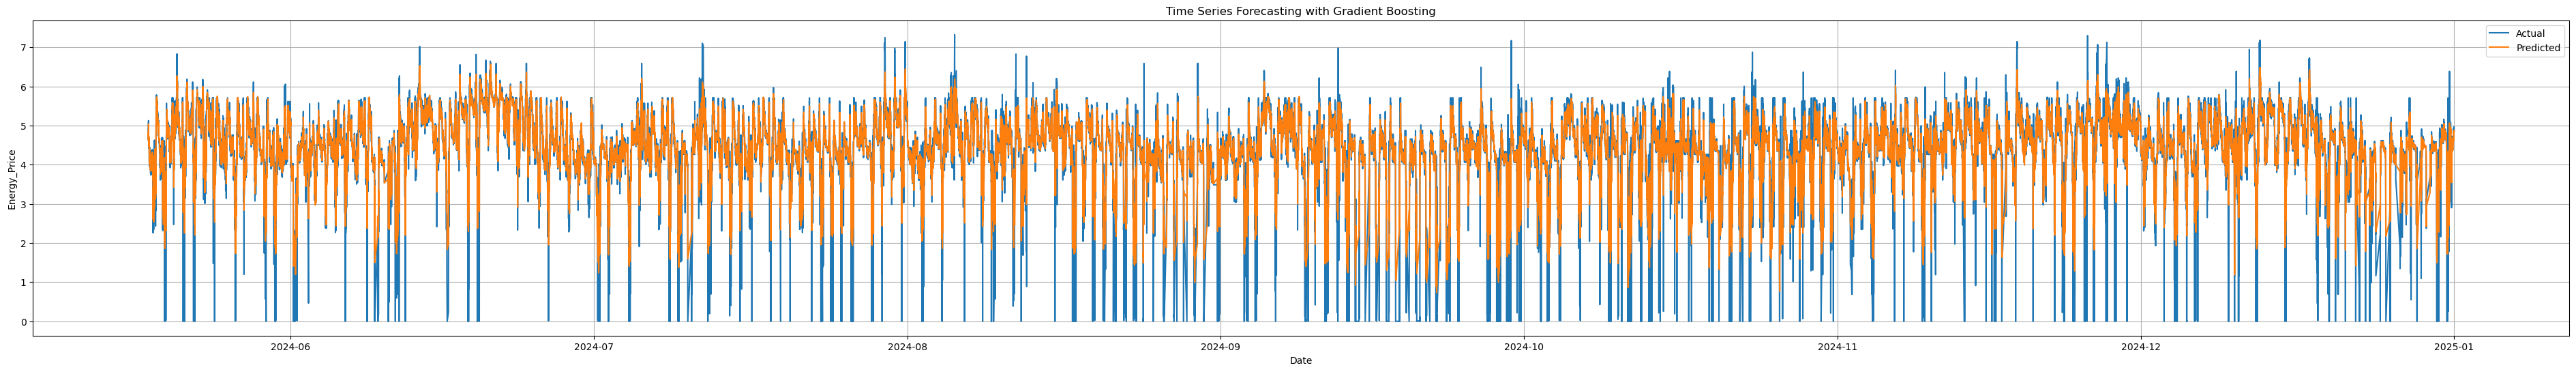

In [50]:
# 1. Prepare the Data

#all other columns are predictors
y = df[df_target]
X = df.drop(columns=[df_target])

# 2. Split the Data into Training and Testing Sets
# It's crucial to split time series data chronologically to avoid data leakage
train_size = int(len(df) * 0.8)  # Use 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 3. Initialize and Train the Gradient Boosting Regressor
# You can tune the hyperparameters for better performance
#xgbm = xgb.XGBRegressor(n_estimators=100,  # Number of boosting stages
                                #learning_rate=0.1, # Step size shrinkage to prevent overfitting
                                #max_depth=5,       # Maximum depth of the individual regression estimators
                                #random_state=42)  # For reproducibility

# Define parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],  # -1 = no limit
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

#print the best parameters
print("Best parameters found: ", xgbm.best_params_)

# Create XGB Regressor
xgb_base = xgb.XGBRegressor(random_state=42)

# Setup Randomized Search
xgbm = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,              # Number of parameter sets to try
    scoring='neg_root_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error', etc.
    cv=5,                   # Cross-validation folds
    verbose=2,
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)

xgbm.fit(X_train, y_train)

#print the best parameters
print("Best parameters found: ", xgbm.best_params_)

# 4. Make Predictions on the Test Set
predictions = xgbm.predict(X_test)

# 5. Evaluate the Model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error on the Test Set: {mse:.4f}")
print(f"Root Mean Squared Error on the Test Set: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# 6. Visualize the Results
plt.figure(figsize=(48, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], predictions, label='Predicted')
plt.title('Time Series Forecasting with Gradient Boosting')
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()


In [51]:
# Feature importance
best_model = xgbm.best_estimator_
importances = best_model.feature_importances_

for feature, importance in zip(X_train.columns, importances):
    print(f"{feature}: {importance}")

Energy_Demand: 0.03062266856431961
Crude_Oil_Price: 0.011439948342740536
Natural_Gas_Price: 0.0070571391843259335
Rainfall: 0.0033663632348179817
Carbon_Intensity: 0.00647654989734292
Renewable_Energy_Percentage: 0.005002992227673531
Temperature: 0.007408456411212683
Solar_Exposure: 0.007896375842392445
hour: 0.020586539059877396
dayofweek: 0.0035942504182457924
month: 0.0041596293449401855
lag_1: 0.4319133758544922
lag_12: 0.03861904889345169
lag_288: 0.05419360473752022
lag_576: 0.01371542178094387
rolling_mean_24: 0.3256116807460785
rolling_std_24: 0.028335999697446823


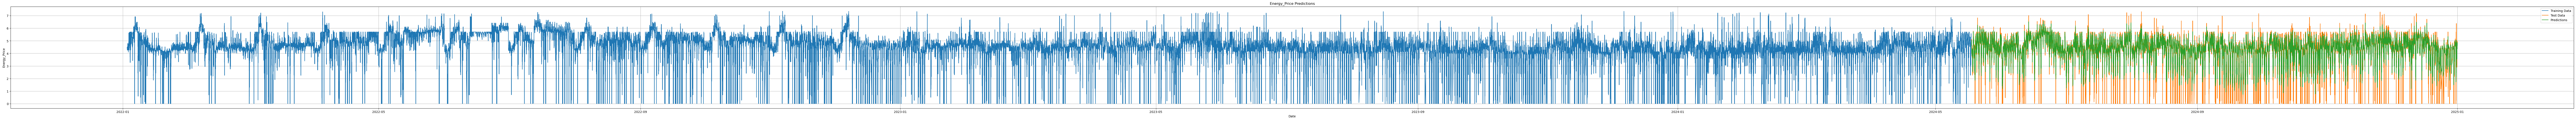

In [52]:
#plot the training data, test data and predictions on test set
plt.figure(figsize=(150, 6))
plt.plot(df.index[:train_size], y_train, label='Training Data')
plt.plot(df.index[train_size:], y_test, label='Test Data')
plt.plot(df.index[train_size:], predictions, label='Predictions')
plt.title(f"{df_target} Predictions")
plt.xlabel('Date')
plt.ylabel(f"{df_target}")
plt.legend()
plt.grid(True)
plt.show()